# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters, kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters=filters, strides=strides)

    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsample = bilinear_upsample(small_ip_layer)

    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concat = layers.concatenate([upsample, large_ip_layer])

    # TODO Add some number of separable convolution layers
    c1 = separable_conv2d_batchnorm(concat, filters=filters, strides=1)
    output_layer = c1

    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
run=1
    
def fcn_model(inputs, num_classes):

    if run==0:
        e1 = encoder_block(inputs, 32, 2)                    # input_layer, filters, strides                   
        m1 = conv2d_batchnorm(e1, 64, 1, 1)                 # input_layer, filters, kernel_size, strides       
        d1 = decoder_block(m1, inputs, 32)                   # small_ip_layer, large_ip_layer, filters

    if run==1:
        e1 = encoder_block(inputs, 32, 2)                    # input_layer, filters, strides                   
        e2 = encoder_block(e1, 64, 2)                        # input_layer, filters, strides 
        m1 = conv2d_batchnorm(e2, 128, 1, 1)                 # input_layer, filters, kernel_size, strides       
        d2 = decoder_block(m1, e1, 64)                       # small_ip_layer, large_ip_layer, filters
        d1 = decoder_block(d2, inputs, 32)                   # small_ip_layer, large_ip_layer, filters
        
    if run==2:
        e1 = encoder_block(inputs, 32, 2)                    # input_layer, filters, strides                   
        e2 = encoder_block(e1, 64, 2)                        # input_layer, filters, strides 
        e3 = encoder_block(e2, 128, 2)                       # input_layer, filters, strides         
        m1 = conv2d_batchnorm(e3, 256, 1, 1)                 # input_layer, filters, kernel_size, strides       
        d3 = decoder_block(m1, e2, 128)                      # small_ip_layer, large_ip_layer, filters
        d2 = decoder_block(d3, e1, 64)                       # small_ip_layer, large_ip_layer, filters
        d1 = decoder_block(d2, inputs, 32)                   # small_ip_layer, large_ip_layer, filters
    
    if run==3:
        e1 = encoder_block(inputs, 32, 2)                    # input_layer, filters, strides                   
        e2 = encoder_block(e1, 64, 2)                        # input_layer, filters, strides 
        e3 = encoder_block(e2, 128, 2)                       # input_layer, filters, strides     
        e4 = encoder_block(e3, 256, 2)                       # input_layer, filters, strides    
        m1 = conv2d_batchnorm(e4, 512, 1, 1)                 # input_layer, filters, kernel_size, strides 
        d4 = decoder_block(m1, e3, 256)                      # small_ip_layer, large_ip_layer, filters
        d3 = decoder_block(d4, e2, 128)                      # small_ip_layer, large_ip_layer, filters
        d2 = decoder_block(d3, e1, 64)                       # small_ip_layer, large_ip_layer, filters
        d1 = decoder_block(d2, inputs, 32)                   # small_ip_layer, large_ip_layer, filters

    if run==4:
        e1 = encoder_block(inputs, 32, 2)                    # input_layer, filters, strides                   
        e2 = encoder_block(e1, 64, 2)                        # input_layer, filters, strides 
        e3 = encoder_block(e2, 128, 2)                       # input_layer, filters, strides         
        m1 = conv2d_batchnorm(e3, 256, 1, 1)                 # input_layer, filters, kernel_size, strides       
        m2 = conv2d_batchnorm(m1, 256, 1, 1)                 # input_layer, filters, kernel_size, strides               
        d3 = decoder_block(m2, e2, 128)                      # small_ip_layer, large_ip_layer, filters
        d2 = decoder_block(d3, e1, 64)                       # small_ip_layer, large_ip_layer, filters
        d1 = decoder_block(d2, inputs, 32)                   # small_ip_layer, large_ip_layer, filters

    if run==5:
        c1 = conv2d_batchnorm(inputs, 32, 1, 1)              # input_layer, filters, kernel_size, strides           
        e1 = encoder_block(c1, 32, 2)                    # input_layer, filters, strides                   
        e2 = encoder_block(e1, 64, 2)                        # input_layer, filters, strides 
        e3 = encoder_block(e2, 128, 2)                       # input_layer, filters, strides         
        m1 = conv2d_batchnorm(e3, 256, 1, 1)                 # input_layer, filters, kernel_size, strides       
        m2 = conv2d_batchnorm(m1, 256, 1, 1)                 # input_layer, filters, kernel_size, strides               
        d3 = decoder_block(m2, e2, 128)                      # small_ip_layer, large_ip_layer, filters
        d2 = decoder_block(d3, e1, 64)                       # small_ip_layer, large_ip_layer, filters
        d1 = decoder_block(d2, inputs, 32)                   # small_ip_layer, large_ip_layer, filters

    if run==6:
        c1 = conv2d_batchnorm(inputs, 32, 1, 1)              # input_layer, filters, kernel_size, strides           
        e1 = encoder_block(c1, 32, 2)                    # input_layer, filters, strides                   
        c2 = conv2d_batchnorm(e1, 64, 1, 1)              # input_layer, filters, kernel_size, strides                   
        e2 = encoder_block(c2, 64, 2)                        # input_layer, filters, strides 
        e3 = encoder_block(e2, 128, 2)                       # input_layer, filters, strides         
        m1 = conv2d_batchnorm(e3, 256, 1, 1)                 # input_layer, filters, kernel_size, strides       
        m2 = conv2d_batchnorm(m1, 256, 1, 1)                 # input_layer, filters, kernel_size, strides               
        d3 = decoder_block(m2, e2, 128)                      # small_ip_layer, large_ip_layer, filters
        d2 = decoder_block(d3, e1, 64)                       # small_ip_layer, large_ip_layer, filters
        d1 = decoder_block(d2, inputs, 32)                   # small_ip_layer, large_ip_layer, filters

    if run==7:
        c1 = conv2d_batchnorm(inputs, 32, 1, 1)              # input_layer, filters, kernel_size, strides           
        e1 = encoder_block(c1, 32, 2)                    # input_layer, filters, strides                   
        c2 = conv2d_batchnorm(e1, 64, 1, 1)              # input_layer, filters, kernel_size, strides                   
        e2 = encoder_block(c2, 64, 2)                        # input_layer, filters, strides 
        c3 = conv2d_batchnorm(e2, 128, 1, 1)              # input_layer, filters, kernel_size, strides                           
        e3 = encoder_block(c3, 128, 2)                       # input_layer, filters, strides         
        m1 = conv2d_batchnorm(e3, 256, 1, 1)                 # input_layer, filters, kernel_size, strides       
        m2 = conv2d_batchnorm(m1, 256, 1, 1)                 # input_layer, filters, kernel_size, strides               
        d3 = decoder_block(m2, e2, 128)                      # small_ip_layer, large_ip_layer, filters
        d2 = decoder_block(d3, e1, 64)                       # small_ip_layer, large_ip_layer, filters
        d1 = decoder_block(d2, inputs, 32)                   # small_ip_layer, large_ip_layer, filters

    if run==8:
        e1 = encoder_block(inputs, 32, 2)                    # input_layer, filters, strides                   
        e2 = encoder_block(e1, 128, 2)                        # input_layer, filters, strides 
        e3 = encoder_block(e2, 256, 2)                       # input_layer, filters, strides     
        e4 = encoder_block(e3, 512, 2)                       # input_layer, filters, strides    
        m1 = conv2d_batchnorm(e4, 1024, 1, 1)                 # input_layer, filters, kernel_size, strides 
        d4 = decoder_block(m1, e3, 512)                      # small_ip_layer, large_ip_layer, filters
        d3 = decoder_block(d4, e2, 256)                      # small_ip_layer, large_ip_layer, filters
        d2 = decoder_block(d3, e1, 128)                       # small_ip_layer, large_ip_layer, filters
        d1 = decoder_block(d2, inputs, 32)                   # small_ip_layer, large_ip_layer, filters
        
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(d1)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.005   # 0.001
batch_size = 100    # 64
num_epochs = 20         # 15
steps_per_epoch =  4131//batch_size+1    # 1000
validation_steps = 1184//batch_size+1   # 50
workers = 4             # 4

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 160, 160, 3)   0                                            
____________________________________________________________________________________________________
separable_conv2d_keras_1 (Separa (None, 80, 80, 32)    155         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 80, 80, 32)    128         separable_conv2d_keras_1[0][0]   
____________________________________________________________________________________________________
separable_conv2d_keras_2 (Separa (None, 40, 40, 64)    2400        batch_normalization_1[0][0]      
___________________________________________________________________________________________

C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


41/42 [============================>.] - ETA: 0s - loss: 0.5864

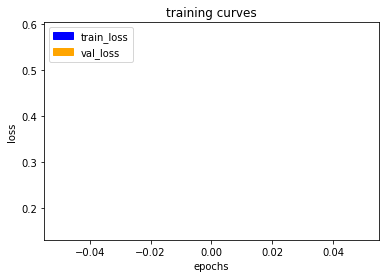

42/42 [==============================] - 43s - loss: 0.5758 - val_loss: 0.1526
Epoch 2/20
35/42 [========================>.....] - ETA: 6s - loss: 0.0856

ResourceExhaustedError: OOM when allocating tensor with shape[100,160,160,32]
	 [[Node: gradients/batch_normalization_5/moments/SquaredDifference_grad/sub = Sub[T=DT_FLOAT, _class=["loc:@batch_normalization_5/moments/SquaredDifference"], _device="/job:localhost/replica:0/task:0/gpu:0"](separable_conv2d_keras_4/Relu, batch_normalization_5/moments/StopGradient, ^gradients/batch_normalization_5/moments/variance_grad/truediv)]]

Caused by op 'gradients/batch_normalization_5/moments/SquaredDifference_grad/sub', defined at:
  File "C:\ProgramData\Anaconda3\envs\robond\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\ProgramData\Anaconda3\envs\robond\lib\asyncio\base_events.py", line 345, in run_forever
    self._run_once()
  File "C:\ProgramData\Anaconda3\envs\robond\lib\asyncio\base_events.py", line 1312, in _run_once
    handle._run()
  File "C:\ProgramData\Anaconda3\envs\robond\lib\asyncio\events.py", line 125, in _run
    self._callback(*self._args)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\zmq\eventloop\zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\IPython\core\interactiveshell.py", line 2907, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-330b2c7410a1>", line 1, in <module>
    get_ipython().run_cell_magic('time', '', '"""\nDON\'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"""\n# Define the Keras model and compile it for training\nmodel = models.Model(inputs=inputs, outputs=output_layer)\nmodel.summary()\n\nmodel.compile(optimizer=keras.optimizers.Adam(learning_rate), loss=\'categorical_crossentropy\')\n\n# Data iterators for loading the training and validation data\ntrain_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,\n                                               data_folder=os.path.join(\'..\', \'data\', \'train_combined\'),\n                                               image_shape=image_shape,\n                                               shift_aug=True)\n\nval_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,\n                                             data_folder=os.path.join(\'..\', \'data\', \'validation\'),\n                                             image_shape=image_shape)\n\nlogger_cb = plotting_tools.LoggerPlotter()\ncallbacks = [logger_cb]\n\nmodel.fit_generator(train_iter,\n                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,\n                    epochs = num_epochs, # the number of epochs to train for,\n                    validation_data = val_iter, # validation iterator\n                    validation_steps = validation_steps, # the number of batches to validate on\n                    callbacks=callbacks,\n                    workers = workers)')
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\IPython\core\interactiveshell.py", line 2167, in run_cell_magic
    result = fn(magic_arg_s, cell)
  File "<decorator-gen-63>", line 2, in time
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\IPython\core\magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\IPython\core\magics\execution.py", line 1237, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 29, in <module>
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tensorflow\contrib\keras\python\keras\engine\training.py", line 1750, in fit_generator
    self._make_train_function()
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tensorflow\contrib\keras\python\keras\engine\training.py", line 926, in _make_train_function
    self._collected_trainable_weights, self.constraints, self.total_loss)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tensorflow\contrib\keras\python\keras\optimizers.py", line 454, in get_updates
    grads = self.get_gradients(loss, params)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tensorflow\contrib\keras\python\keras\optimizers.py", line 95, in get_gradients
    grads = K.gradients(loss, params)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tensorflow\contrib\keras\python\keras\backend.py", line 2453, in gradients
    loss, variables, colocate_gradients_with_ops=True)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 542, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 348, in _MaybeCompile
    return grad_fn()  # Exit early
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 542, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tensorflow\python\ops\math_grad.py", line 838, in _SquaredDifferenceGrad
    x_grad = math_ops.scalar_mul(2.0, grad) * (x - y)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tensorflow\python\ops\math_ops.py", line 865, in binary_op_wrapper
    return func(x, y, name=name)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 2629, in _sub
    result = _op_def_lib.apply_op("Sub", x=x, y=y, name=name)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tensorflow\python\framework\ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tensorflow\python\framework\ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'batch_normalization_5/moments/SquaredDifference', defined at:
  File "C:\ProgramData\Anaconda3\envs\robond\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
[elided 21 identical lines from previous traceback]
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-c10f06bfa326>", line 11, in <module>
    output_layer = fcn_model(inputs, num_classes)
  File "<ipython-input-6-85021bb35481>", line 15, in fcn_model
    d1 = decoder_block(d2, inputs, 32)                   # small_ip_layer, large_ip_layer, filters
  File "<ipython-input-5-9f33ea21a401>", line 10, in decoder_block
    c1 = separable_conv2d_batchnorm(concat, filters=filters, strides=1)
  File "<ipython-input-2-490811f091e6>", line 5, in separable_conv2d_batchnorm
    output_layer = layers.BatchNormalization()(output_layer)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tensorflow\contrib\keras\python\keras\engine\topology.py", line 396, in __call__
    output = super(Layer, self).__call__(inputs, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tensorflow\python\layers\base.py", line 450, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tensorflow\contrib\keras\python\keras\layers\normalization.py", line 119, in call
    output = super(BatchNormalization, self).call(inputs, training=training)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tensorflow\python\layers\normalization.py", line 370, in call
    mean, variance = nn.moments(inputs, reduction_axes)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tensorflow\python\ops\nn_impl.py", line 621, in moments
    math_ops.squared_difference(y, array_ops.stop_gradient(mean)),
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 2610, in squared_difference
    result = _op_def_lib.apply_op("SquaredDifference", x=x, y=y, name=name)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tensorflow\python\framework\ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\tensorflow\python\framework\ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[100,160,160,32]
	 [[Node: gradients/batch_normalization_5/moments/SquaredDifference_grad/sub = Sub[T=DT_FLOAT, _class=["loc:@batch_normalization_5/moments/SquaredDifference"], _device="/job:localhost/replica:0/task:0/gpu:0"](separable_conv2d_keras_4/Relu, batch_normalization_5/moments/StopGradient, ^gradients/batch_normalization_5/moments/variance_grad/truediv)]]


In [9]:
%%time
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)
model.summary()

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train_combined'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [11]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [12]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


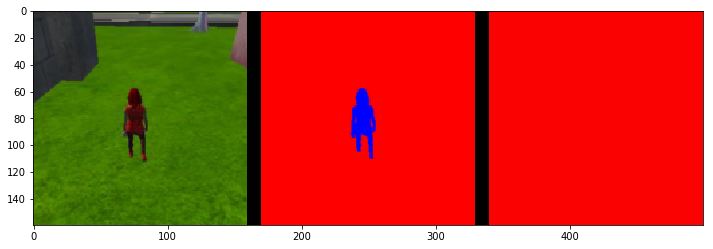

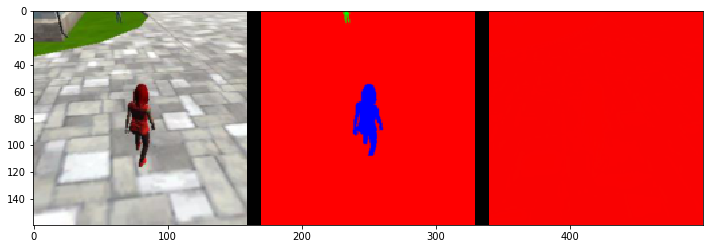

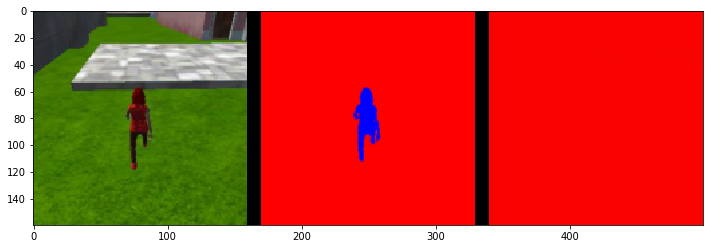

In [13]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


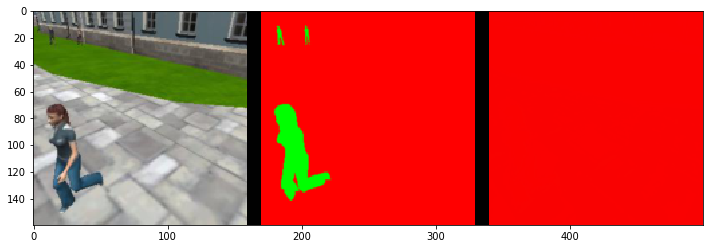

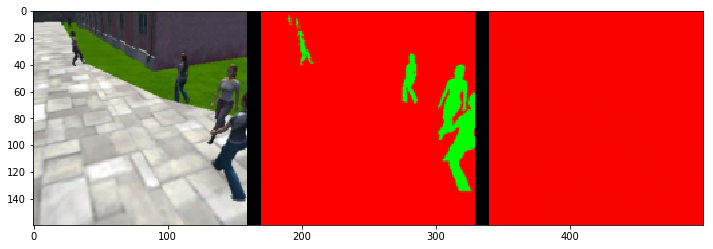

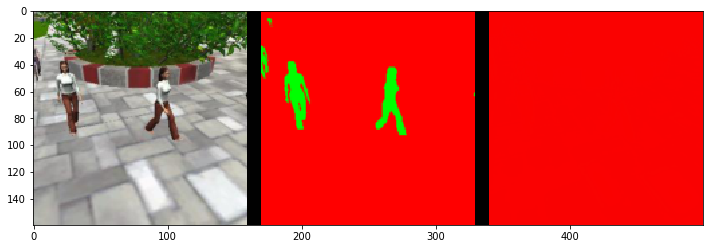

In [14]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


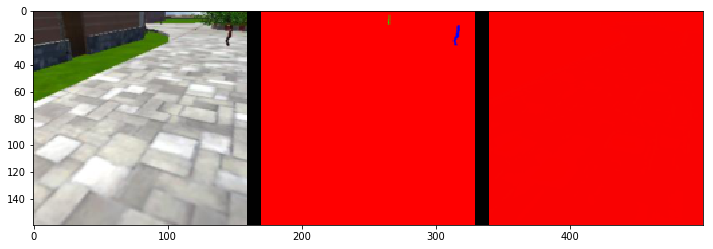

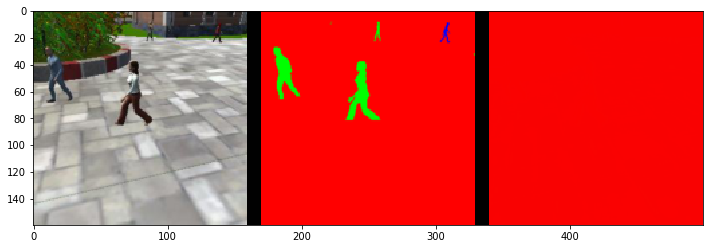

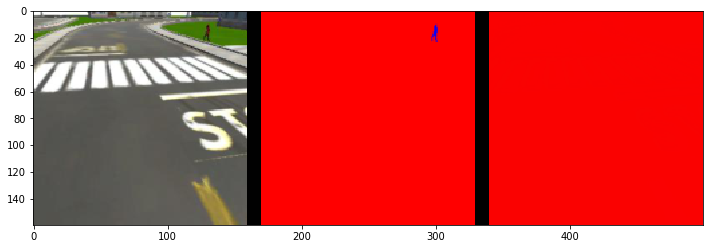

In [15]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [16]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9719131976476029
average intersection over union for other people is 0.0
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 0, number false negatives: 539


In [17]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.954649016203703
average intersection over union for other people is 0.0
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 0, number false negatives: 0


In [18]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\ProgramData\Anaconda3\envs\robond\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9897817595108703
average intersection over union for other people is 0.0
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 0, number false negatives: 301


In [19]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.0


In [20]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.0


In [21]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.0


In [22]:
print (run)


1
